In [1]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import sys

In [11]:
def process_df(df):

    def process(i, text):
        nonlocal df
        sys.stdout.write("\r% 3d%%"%(i/len(df)*100))
        text = str(text)
        text = re.sub(r'[^\w,.!?\s]', ' ', text)
        text = re.sub(r'\d+', '0 ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\d+\s)+', '0', text)
        if not 50 <= len(text) < 200:
            return ''
        if re.compile(r'[a-zA-Zㄱ-ㅎㅏ-ㅣ]').search(text):
            return ''
        if re.compile(r'.*(.+?)\1{2}.*').search(text):
            return ''
        if re.compile(r'.*\w{10}.*').search(text):
            return ''
        text = re.sub(r'[.,!?]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'^ ', '', text)
        text = re.sub(r' $', '', text)
        return text
        
    df = df.copy()
    df = df[df['point'] > 0]
    texts = [process(i, t) for i, t in enumerate(df['text'])]
    sys.stdout.write("\r100%")
    df['text'] = texts
    df = df[df['text'] != '']    
    df = df.reset_index(drop=True)
    
    return df

In [12]:
def get_meta(df):

    def calc_loss(bound):
        nonlocal keys
        b0, b1 = keys.index(bound[0]), keys.index(bound[1])
        counts = [label2count[key] for key in keys]
        l0, l1, l2 = counts[:b0], counts[b0:b1], counts[b1:]
        merged_counts = [sum(l0), sum(l1), sum(l2)]
        loss = np.std(merged_counts)
        return loss, merged_counts

    labels = list(set(df['point']))
    label2count = {key: 0 for key in labels}
    for point in df['point']:
        label2count[point] += 1
        
    keys = sorted(list(label2count))
    bounds = [[keys[i], keys[j]]
              for i in range(len(keys))
              for j in range(i+1, len(keys))]
    boundary = min(bounds, key=calc_loss)
    counts = calc_loss(boundary)[1]

    return boundary, counts, label2count

In [13]:
def concat_lebel(df, boundary):
    
    def get_label(i, p):
        nonlocal df
        sys.stdout.write("\r% 3d%%"%(i/len(df)*100))
        if p < boundary[0]:
            label = 'neg'
        elif p < boundary[1]:
            label = 'neu' 
        else:
            label = 'pos'
        return label

    label = [get_label(i, p) for i, p in enumerate(df['point'])]
    sys.stdout.write("\r%100%")
    df['label'] = label

    return df

In [14]:
def concat_fake(df):
    
    def get_fake(i, text):
        nonlocal df
        sys.stdout.write("\r% 3d%%"%(i/len(df)*100))
        while True:
            words = np.array(text.split())
            idxs = np.array(range(len(words)))
            shuffled_idxs = idxs.copy()
            np.random.shuffle(shuffled_idxs)
            if sum(idxs == shuffled_idxs) < len(idxs)*0.8:
                shuffled_text = " ".join(words[shuffled_idxs])
                break
            else:
                print(words)
                break
        return shuffled_text

    np.random.seed(0)
    fake = [get_fake(i, t) for i, t in enumerate(df['text'])]
    sys.stdout('\r100%')
    df['fake'] = fake
    
    return df

## 데이타 로드

In [6]:
raw_df = pd.read_csv("./data/watcha_movie_review.csv")

## 전처리

In [9]:
df = process_df(raw_df)
df.to_pickle("./data/proc_df")

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  0%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  1%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

  2%

KeyboardInterrupt: 

## 하이퍼 파라미터 및 메타 정보 획득

In [7]:
boundary, counts, label2count = get_meta(df)

## 레이블 달기

In [59]:
df = concat_lebel(df, boundary)

## 가짜 문장 만들기

In [64]:
df = concat_fake(df)

KeyboardInterrupt: 

## 리포트

총 리뷰 수:	 6569690


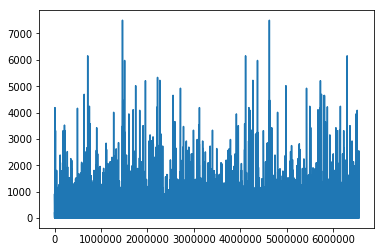

전처리 후 리뷰 수:	 121400
	0.5 점 리뷰 수:	 1555
	1.0 점 리뷰 수:	 1742
	1.5 점 리뷰 수:	 2072
	2.0 점 리뷰 수:	 4612
	2.5 점 리뷰 수:	 6780
	3.0 점 리뷰 수:	 15229
	3.5 점 리뷰 수:	 21416
	4.0 점 리뷰 수:	 30754
	4.5 점 리뷰 수:	 17812
	5.0 점 리뷰 수:	 19428


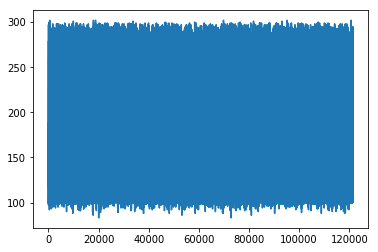

최적 경계선:	 [3.5, 4.5]
경계별 리뷰 수
	부정:	31990
	중립:	52170
	긍정:	37240


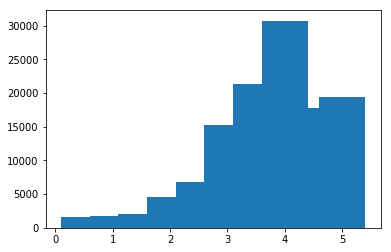

In [13]:
print("총 리뷰 수:\t", len(raw_df))
lengths = [len(sen) for sen in raw_df["text"] if type(sen) == str]
plt.plot(lengths)
plt.show()

print("전처리 후 리뷰 수:\t", len(df))
keys = sorted(list(label2count))
for key in keys:
    print("\t%.1f 점 리뷰 수:\t" % key, label2count[key])
lengths = [len(sen) for sen in df["text"]]
plt.plot(lengths)
plt.show()

print("최적 경계선:\t", boundary)
print("경계별 리뷰 수")
names = ['부정', '중립', '긍정']
for i in range(len(counts)):
    print("\t%s:\t%s" % (names[i], counts[i]))

plt.bar(keys, [label2count[key] for key in keys])
plt.show()

In [ ]:
df.to_pickle("./data/df")
fake_df.to_pickle("./data/fake_df")